In [2]:
from torchinfo import summary
from torchmetrics import Accuracy
import torch
import mlflow
import mlflow.pytorch

# connect the experiment to the tracking server
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# set the experiment name
mlflow.set_experiment("SPAD-UNet-model")

# enable autologging
mlflow.pytorch.autolog()


In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module.
    Ensures deterministic behavior on CPU, CUDA, and MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # Works for CPU & MPS

    if torch.backends.mps.is_available():
        print("MPS backend is available. It uses the global PyTorch seed.")

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True, warn_only=True)

    print(f"Seed set to: {seed}")

# Example usage
set_seed(42)

MPS backend is available. It uses the global PyTorch seed.
Seed set to: 42


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SPAD_DATASET(Dataset):
    def __init__(self, image_dir, depth_dir, transform=None, depth_transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.transform = transform
        self.depth_transform = depth_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Load Ground Truth depth Image
        depth_path = os.path.join(self.depth_dir, img_name)
        depth_image = Image.open(depth_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)

        return image, depth_image

# Separate transforms
input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

depth_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

g = torch.Generator()
g.manual_seed(42)

# Create Dataloaders
train_dataset = SPAD_DATASET(image_dir='competition-data/training-images', depth_dir='competition-data/training-depths',
                         transform=input_transform, depth_transform=depth_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=0, generator=g)

val_dataset = SPAD_DATASET(image_dir='competition-data/validation-images', depth_dir='competition-data/validation-depths',
                       transform=input_transform, depth_transform=depth_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, generator=g)

In [6]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, base_c= 16, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.encoder_conv_1 = self.conv_block(in_channels, base_c)
        self.encoder_conv_2 = self.conv_block(base_c, base_c*2)
        self.encoder_conv_3 = self.conv_block(base_c*2, base_c*4)
        self.encoder_conv_4 = self.conv_block(base_c*4, base_c*8)
        self.bottleneck = self.conv_block(base_c*8, base_c*16)

        self.upconv4 = nn.ConvTranspose2d(base_c*16, base_c*8, 2, 2)
        self.upconv3 = nn.ConvTranspose2d(base_c*8, base_c*4, 2, 2)
        self.upconv2 = nn.ConvTranspose2d(base_c*4, base_c*2, 2, 2)
        self.upconv1 = nn.ConvTranspose2d(base_c*2, base_c, 2, 2)

        self.decoder_conv_4 = self.conv_block(base_c*16, base_c*8)
        self.decoder_conv_3 = self.conv_block(base_c*8, base_c*4)
        self.decoder_conv_2 = self.conv_block(base_c*4, base_c*2)
        self.decoder_conv_1 = self.conv_block(base_c*2, base_c)

        self.final = nn.Conv2d(base_c, out_channels, 1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

    def downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

    def upsample(self, x):
        return nn.ConvTranspose2d(x.size(1), x.size(1) // 2, kernel_size=2, stride=2)(x)

    def forward(self, x):
        # Encoder
        enc_1 = self.encoder_conv_1(x)
        down_1 = self.downsample(enc_1)

        enc_2 = self.encoder_conv_2(down_1)
        down_2 = self.downsample(enc_2)

        enc_3 = self.encoder_conv_3(down_2)
        down_3 = self.downsample(enc_3)

        enc_4 = self.encoder_conv_4(down_3)
        down_4 = self.downsample(enc_4)


        # Bottleneck
        bottleneck = self.bottleneck(down_4)


        # Decoder
        up_4 = self.upconv4(bottleneck)
        skip_conn_4 = torch.cat((up_4, enc_4), dim=1)
        dec_4 = self.decoder_conv_4(skip_conn_4)

        up_3 = self.upconv3(dec_4)
        skip_conn_3 = torch.cat((up_3, enc_3), dim=1)
        dec_3 = self.decoder_conv_3(skip_conn_3)

        up_2 = self.upconv2(dec_3)
        skip_conn_2 = torch.cat((up_2, enc_2), dim=1)
        dec_2 = self.decoder_conv_2(skip_conn_2)

        up_1 = self.upconv1(dec_2)
        skip_conn_1 = torch.cat((up_1, enc_1), dim=1)
        dec_1 = self.decoder_conv_1(skip_conn_1)

        # Final output
        output = self.final(dec_1)

        return output


In [ ]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    epoch_loss = 0

    for images, edges in train_loader:
        images, edges = images.to(device), edges.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, edges)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    mlflow.log_metric("train_loss", epoch_loss / len(train_loader), step=epoch+1)
    print(f"Epoch {epoch+1}: Train Loss = {epoch_loss / len(train_loader)}")

def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, edges in val_loader:
            images, edges = images.to(device), edges.to(device)
            outputs = model(images)
            loss = criterion(outputs, edges)
            total_loss += loss.item()
    
    mse = total_loss / len(val_loader)
    rmse = mse**0.5
    
    print(f"Epoch {epoch+1} - Val Loss (MSE): {mse}, RMSE: {rmse}")
    
    mlflow.log_metric("val_loss", mse, step=epoch)
    mlflow.log_metric("val_RMSE", rmse, step=epoch)


In [ ]:
import torch.optim as optim
# Initialize model, criterion, and optimizer
model = UNet()
criterion = nn.MSELoss()
lrate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lrate)
num_epochs = 50

# Log params as a dictionary
params = {
    "learning_rate": lrate,
    "loss_function": "MSELoss",
    "optimizer": "Adam",
    "epochs": num_epochs
}

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
model.to(device)
        
with mlflow.start_run():
    mlflow.log_params(params)
    for epoch in range(num_epochs):
        train(model, train_loader, criterion, optimizer, device, epoch)
        validate(model, val_loader, criterion, device, epoch)
    
    # Log the model artifact to that run
    mlflow.pytorch.log_model(model)
    
    with open("model_report.txt", "w") as f:
        # Write architecture
        f.write("### MODEL ARCHITECTURE ###\n")
        f.write(str(model))
        f.write("\n\n### MODEL SUMMARY ###\n")
        # Write summary
        summary(model, input_size=(1, 1, 256, 256), device=device.type, file=f)

    # Log to MLflow
    mlflow.log_artifact("model_report.txt")


In [5]:
import torch
model = torch.load("../mlartifacts/243770936088077455/9107bc247a2147b6ab63da8a5c14c2a2/artifacts/models/data/model.pth", weights_only=False)
model.eval()


UNet(
  (encoder_conv_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv_4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequenti

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def plot_results(model, dataloader, device='mps', num_batches=2):
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            label = label.unsqueeze(1).to(device)  # Shape: [B, 1, H, W]

            outputs = model(images)               # Shape: [B, 1, H, W]
            outputs = outputs * 0.5 + 0.5         # Denormalize if needed
            outputs = outputs.squeeze(1)          # Shape: [B, H, W]

            for i in range(len(images)):
                pred = outputs[i].cpu()
                # If prediction is float, convert to uint8 in [0, 255]
                pred = (pred * 255).clamp(0, 255).byte()

                pred_img = Image.fromarray(pred.numpy(), mode='L')

                # Plotting
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(label[i].cpu().squeeze(), cmap='gray')
                plt.title("Ground Truth Depth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_img, cmap='gray')
                plt.title("Predicted Depth")

                plt.show()

            batch_count += 1
            if batch_count >= num_batches:
                break


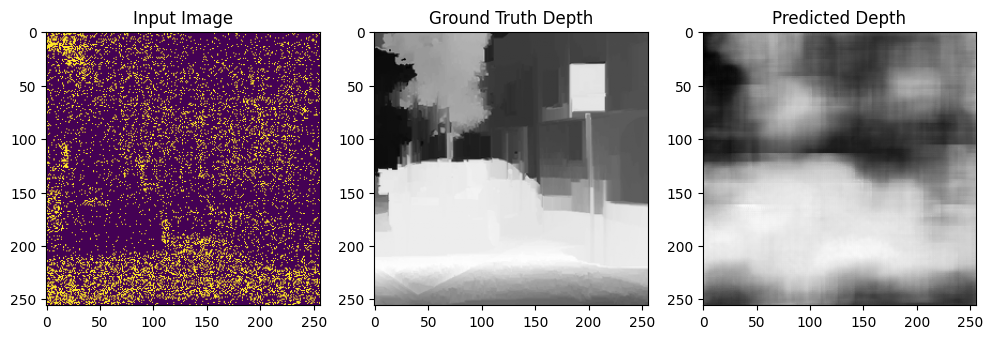

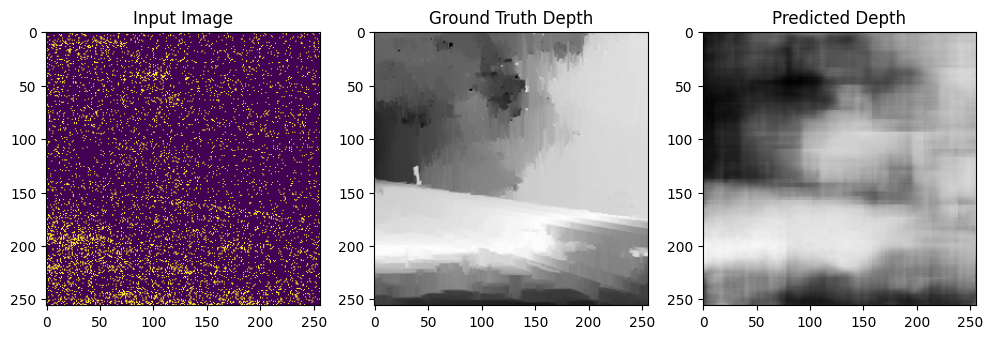

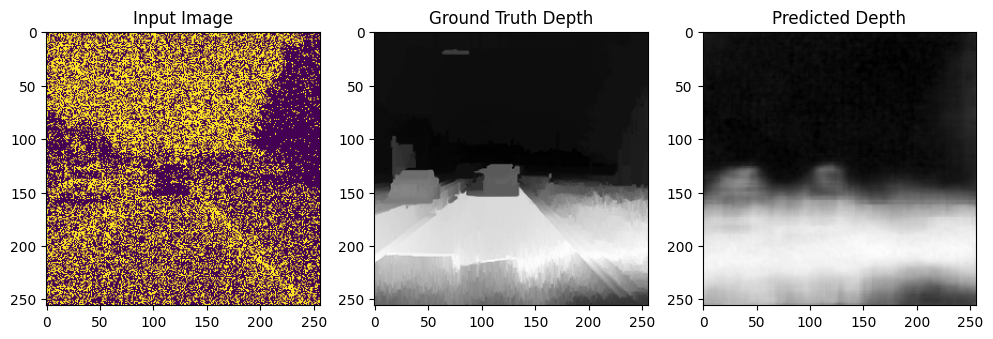

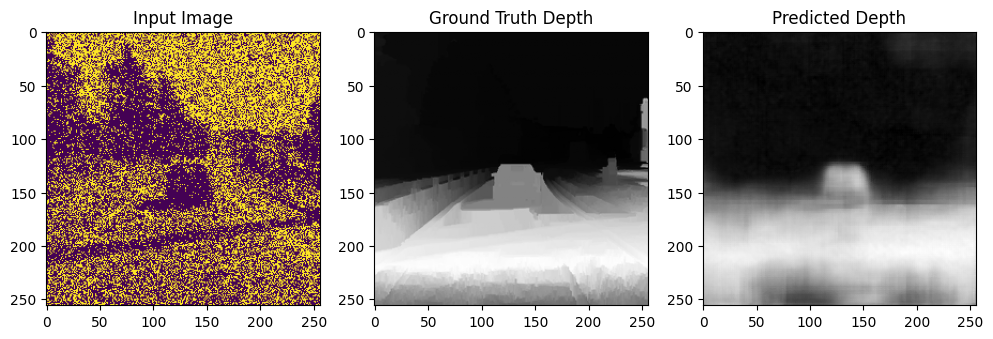

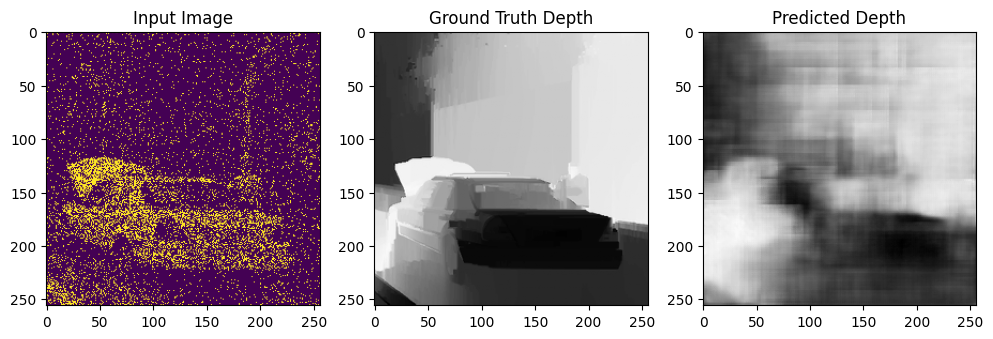

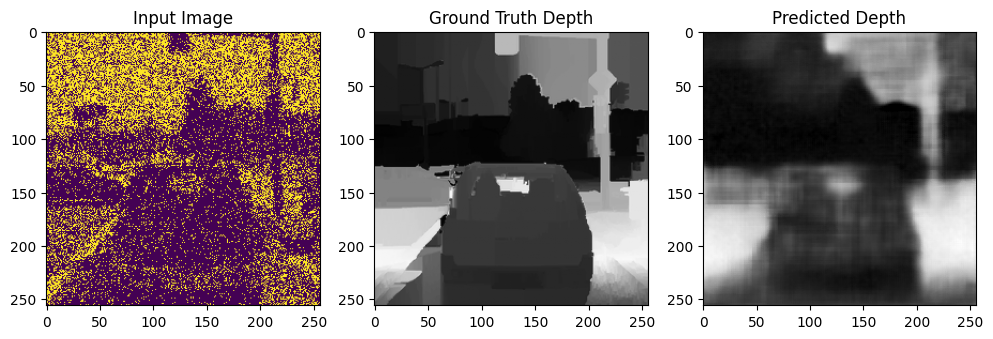

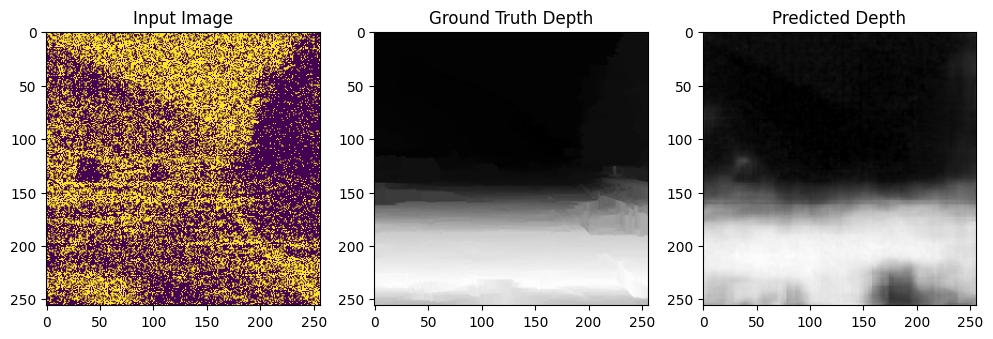

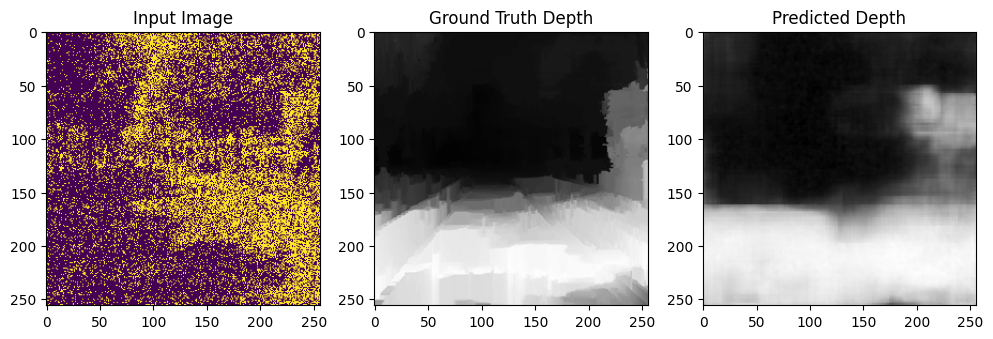

In [7]:
plot_results(model, val_loader, device='mps', num_batches=2)

In [11]:
class SPAD_DATASET_test(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, img_name

# Separate transforms
input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [12]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_and_save(model, dataloader, device='mps', output_dir='competition-data/predicted_depths'):
    model.eval()  # Set the model to evaluation mode
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the image transformation (optional based on your model)
    transform = transforms.ToPILImage()
    
    with torch.no_grad():
        for i, (images, filenames) in enumerate(dataloader):  # Assuming filenames are returned along with images
            images = images.to(device)
            
            # Get the model output
            outputs = model(images)
            outputs = outputs * 0.5 + 0.5  # Denormalize if needed
            outputs = outputs.squeeze(1)  # Assuming single channel output
            
            for idx in range(len(images)):
                # Convert output to PIL Image and save with same name as input image
                output_img = outputs[idx].cpu()
                output_img = (output_img * 255).clamp(0, 255).byte()  # Convert to uint8
                
                # Extract original image name
                original_name = filenames[idx]  # Assuming `filenames` contains original names (e.g., list of file names)
                output_path = os.path.join(output_dir, original_name)  # Save using the original name
                
                # Convert tensor to PIL Image and save
                output_pil = transform(output_img)  # Convert tensor to PIL Image
                output_pil.save(output_path)

                print(f"Saved prediction for image {original_name}")

# Example usage:
test_dataset = SPAD_DATASET_test(image_dir='competition-data/testing-images', transform=input_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, generator=g)
predict_and_save(model, test_loader)


Saved prediction for image 16153231.png
Saved prediction for image 24854972.png
Saved prediction for image 5751152.png
Saved prediction for image 185372.png
Saved prediction for image 23254652.png
Saved prediction for image 36657332.png
Saved prediction for image 39757951.png
Saved prediction for image 25755151.png
Saved prediction for image 11252252.png
Saved prediction for image 35257052.png
Saved prediction for image 29255852.png
Saved prediction for image 355712.png
Saved prediction for image 32356472.png
Saved prediction for image 6951392.png
Saved prediction for image 165331.png
Saved prediction for image 26955391.png
Saved prediction for image 17753551.png
Saved prediction for image 18253651.png
Saved prediction for image 33756751.png
Saved prediction for image 9251851.png
Saved prediction for image 14052811.png
Saved prediction for image 22954592.png
Saved prediction for image 19553911.png
Saved prediction for image 485972.png
Saved prediction for image 39857971.png
Saved predi